In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from cnmf_e import init_ring_model, init_neurons_ding, update_ring_model_w

## load preprocessed data

In [2]:
data = np.load("cnmfe_init_output.npz")
print(data.files)
U = data['arr_0']
V = data['arr_1']
A = data['arr_2']
X = data['arr_3']
d1, d2, T, r = data['arr_4']
print(d1, d2, r, T)

['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4']
252 304 13 2000


## Verify init_ring_model()

In [3]:
print(U.shape, V.shape, A.shape, X.shape)
U_ax, W = init_ring_model(U, d1, d2, r)
print(U_ax.shape, W.shape)

(76608, 50) (50, 2000) (76608, 200) (200, 50)
(76608, 50) (76608, 76608)


In [4]:
# cor = [0] * 50
# for i in range(50):
#     cor[i] = np.inner(U[:,i], U_ax[:, i]) / np.linalg.norm(U[:, i]) / np.linalg.norm(U_ax[:, i])

In [5]:
video_bef = np.matmul(U, V).reshape(252, 304, -1)
print(video_bef.shape)

(252, 304, 2000)


In [6]:
B = W.dot(U - U_ax)
video_after = np.matmul(U - B, V).reshape(252, 304, 2000)

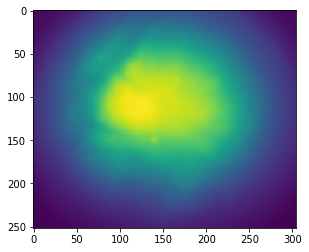

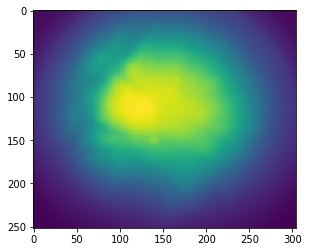

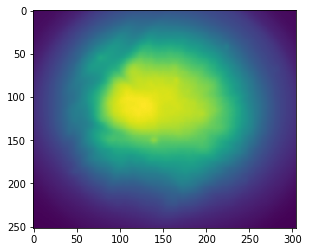

In [7]:
for i in range(1000, 1003):
    row = video_bef[:, :, i]
    im=plt.imshow(row)
    im.set_data(row)
    plt.pause(0.02)
plt.show()

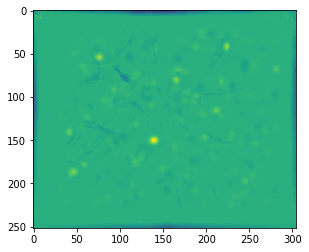

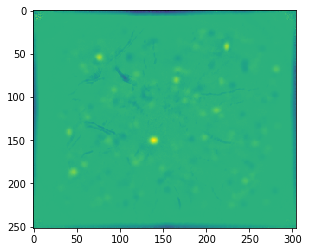

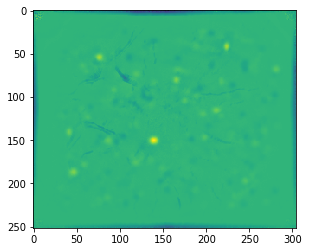

In [8]:
for i in range(1000, 1003):
    row = video_after[:, :, i]
    im=plt.imshow(row)
    im.set_data(row)
    plt.pause(0.02)
plt.show()

## Verify init_neurons_ding() fcn

In [18]:
P1 = np.reshape(U - W.dot(U - U_ax), (d1, d2, -1))
P1 = np.reshape(P1, (d1*d2, -1), order='F') # init_neurons() use F order
P2 = np.transpose(V)
P0 = np.reshape(np.matmul(U - W.dot(U - U_ax), V), (d1, d2, T), order='F')
A_ding, X_ding = init_neurons_ding(P0, P1, P2, cut_off_point=[0.95, 0.95], length_cut=[10, 10], th=[2, 1], pass_num=1,
                      residual_cut=[0.6, 0.6])

start 1 pass!
find superpixels!
time: 3.1326284408569336
rank 1 svd!
time: 4.250542640686035
find pure superpixels!
time: 0.32443714141845703
prepare iteration!
0.6795601844787598
time: 1.8688714504241943


In [19]:
print(U.shape, A_ding.shape, X_ding.shape, V.shape)

(76608, 50) (76608, 112) (112, 50) (50, 2000)


In [20]:
print(U.shape, A.shape, X.shape, V.shape)

(76608, 50) (76608, 200) (200, 50) (50, 2000)


In [21]:
C = np.matmul(X, V)
C_ding = np.matmul(X_ding, V)
print(C.shape, C_ding.shape)

(200, 2000) (112, 2000)


In [22]:
corr_A, corr_C, idx = [], [], []
for i in range(A.shape[1]):
    maxCorr, maxCorrIdx = 0.0, -1
    A_norm = np.linalg.norm(A[:,i])
    C_norm = np.linalg.norm(C[i,:])
    for j in range(A_ding.shape[1]):
        corr = np.inner(A[:,i], A_ding[:,j]) / A_norm / np.linalg.norm(A_ding[:,j])
#         corr = corr * np.inner(C[i,:], C_ding[j,:]) / C_norm / np.linalg.norm(C_ding[j,:])
        if corr > maxCorr:
            maxCorr = corr
            maxCorrIdx = j
    corr_A.append(np.inner(A[:,i], A_ding[:,maxCorrIdx]) / A_norm / np.linalg.norm(A_ding[:,maxCorrIdx]))
    corr_C.append(np.inner(C[i,:], C_ding[maxCorrIdx,:]) / C_norm / np.linalg.norm(C_ding[maxCorrIdx,:]))
    idx.append(maxCorrIdx)


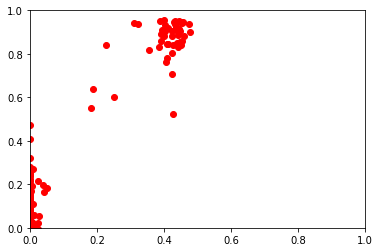

In [23]:
import matplotlib.pyplot as plt
plt.plot(corr_A, corr_C, 'ro')
plt.axis([0, 1, 0, 1])
plt.show()